# Backtest Your Short-Position Algorithm

In this activity, you’ll backtest an algorithm to determine both the changes to the overall portfolio values and the daily return and cumulative return metrics.

## Instructions:

1. Review the provided code. This includes the `import` statements for the required libraries, the creation of the Pandas DataFrame from the `vnq.csv` file in the `Resources` folder, and the code that creates and visualizes the short-position DMAC trading algorithm.

2. Set an `initial_capital` variable to `100000` to represent the starting value ($100,000) of your simulated portfolio. Be sure to create this variable as a floating point number.

3. Set a `share_size` variable to negative 500 shares (-500).

    > **Note** Remember that you’re using a short-position strategy. The objective is to enter the trade by selling shares at a high price before buying them back, or exiting the trade, at a lower price.

4. Create a new column named “Position” by multiplying the `share_size` value by the values in the “Signal” column.

5. Create a new column named “Entry/Exit Position” by calling the `diff` function on the “Position” column.

6. Create a new column named “Portfolio Holdings” by multiplying the “Close” prices of VNQ by the values in the “Position” column.

7. Create a new column named “Portfolio Cash” by subtracting the cumulative sum of the trades that the “Entry/Exit Position” column indicates from the `initial_capital` value.

8. Create a new column named “Portfolio Total” by adding the values of the “Portfolio Cash” and “Portfolio Holdings” columns.

9. Create a new column named “Portfolio Daily Returns” by calling the `pct_change` function on the “Portfolio Total” column.

10. Create a new column named “Portfolio Cumulative Returns” by calling the `cum_prod` function on the “Portfolio Daily Returns” column.

11. Use the `hvplot` function to plot the short-position DMAC trading strategy against its backtesting results.

12. Review the resulting overlay plot. Then answer the following question: Does it appear that this algorithm suits a short-position trading strategy?




## Step 1: Review the provided code. This includes the `import` statements for the required libraries, the creation of the Pandas DataFrame from the `vnq.csv` file in the `Resources` folder, and the code that creates and visualizes the short-position DMAC trading algorithm.

In [9]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report

### Read the CSV file in from the resources folder and create the Pandas DataFrame

In [11]:
# Read the vnq.csv file located in the Resources folder into a Pandas DataFrame
# Set the Date column as the DateTimeIndex
gme_df = pd.read_csv(
    Path("./Resources/GME_5y.csv"),
    index_col="Date",
    parse_dates=True, 
    infer_datetime_format=True
)

# Review the DataFrame
gme_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2016-12-28,25.790001,25.950001,25.080000,25.270000,20.550421,1716100
2016-12-29,25.240000,25.760000,25.240000,25.340000,20.607347,1714800
2016-12-30,25.420000,25.750000,25.219999,25.260000,20.542288,1747800
2017-01-03,25.440001,25.469999,25.020000,25.370001,20.631742,1941400
2017-01-04,25.580000,26.049999,25.580000,25.920000,21.079021,2244300


### Generate a Dual Moving Average Crossover Trading Signal

In [12]:
# Filter the Date index and close columns
signals_df = gme_df.loc[:,["Close"]]
signals_df = signals_df.loc["2019-12-15" : "2021-12-29"]

# Set the short window and long window
short_window = 5
long_window = 13

# Generate the short and long moving averages (50 and 100 days, respectively)
signals_df['SMA_Fast'] = signals_df['Close'].rolling(window=short_window).mean()
signals_df['SMA_Slow'] = signals_df['Close'].rolling(window=long_window).mean()
signals_df['Signal'] = 0.0

# Generate the trading signal 0 or 1,
# where 1 is when the SMA50 is less than the SMA100
# where 0 is when the SMA50 is greater than than the SMA100
signals_df['Signal'][short_window:] = np.where(
    signals_df['SMA_Fast'][short_window:] > signals_df['SMA_Slow'][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
signals_df['Entry/Exit'] = signals_df['Signal'].diff()

# Add a column for actual returns
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Review the DataFrame
signals_df.tail(10)


,Close,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Actual Returns
Date,,,,,,
2021-12-13,136.880005,160.621997,177.979998,0.0,0.0,-0.139174
2021-12-14,147.690002,154.597998,173.049998,0.0,0.0,0.078974
2021-12-15,148.589996,149.585999,169.116921,0.0,0.0,0.006094
2021-12-16,144.589996,147.351999,164.699998,0.0,0.0,-0.026920
2021-12-17,155.639999,146.678000,161.579228,0.0,0.0,0.076423
2021-12-20,157.139999,150.729998,159.833075,0.0,0.0,0.009638
2021-12-21,158.119995,152.815997,158.029998,0.0,0.0,0.006236
2021-12-22,154.000000,153.897998,156.615382,0.0,0.0,-0.026056
2021-12-23,152.139999,155.407998,155.463075,0.0,0.0,-0.012078


In [ ]:
signals_df['Signal'].value_counts()

In [ ]:
# Calculate the strategy returns and add them to the signals_df DataFrame
signals_df['Strategy Returns'] = signals_df['Actual Returns'] * signals_df['Signal'].shift()

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

In [ ]:
# Plot Strategy Returns to examine performance
(1 + signals_df['Strategy Returns']).cumprod().plot()

In [ ]:
# Assign a copy of the sma_fast and sma_slow columns to a features DataFrame called X
X = signals_df[['SMA_Fast', 'SMA_Slow']].shift().dropna()

# Review the DataFrame
X.head()

In [ ]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df['Signal'] 

# Review the value counts
y.value_counts()

In [ ]:
# Select the start of the training period
training_begin = X.index.min()

# Display the training begin date
print(training_begin)

In [ ]:
# Select the ending period for the training data with an offset of 3 months
training_end = X.index.min() + DateOffset(months=3)

# Display the training end date
print(training_end)

In [ ]:
# Generate the X_train and y_train DataFrames
X_train = X.loc[training_begin:training_end]
y_train = y.loc[training_begin:training_end]

# Review the X_train DataFrame
X_train.head()
X_train.count()

In [ ]:
# Generate the X_test and y_test DataFrames
X_test = X.loc[training_end+DateOffset(hours=1):]
#X.loc[training_end+DateOffset(hours=1):]
y_test = y.loc[training_end+DateOffset(hours=1):]
#y.loc[training_end+DateOffset(hours=1):]

# Review the X_test DataFrame
display(X_test.count())
X_test

In [ ]:
# Scale the features DataFrames

# Create a StandardScaler instance
scaler = StandardScaler()

# Apply the scaler model to fit the X-train data
X_scaler = scaler.fit(X_train)

# Transform the X_train and X_test DataFrames using the X_scaler
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

#X_test_scaled[:2000]

In [ ]:
# From SVM, instantiate SVC classifier model instance
svm_model = svm.SVC()
 
# Fit the model to the data using the training data
svm_model = svm_model.fit(X_train_scaled, y_train)
 
# Use the testing data to make the model predictions
svm_pred = svm_model.predict(X_test_scaled)

# Review the model's predicted values
#svm_pred[:2000]


In [ ]:
# Use a classification report to evaluate the model using the predictions and testing data
svm_testing_report = classification_report(y_test, svm_pred)
# Print the classification report

print(svm_testing_report)


In [ ]:
# Create a new empty predictions DataFrame.

# Create a predictions DataFrame
predictions_df = pd.DataFrame(index=X_test.index)
# Add the SVM model predictions to the DataFrame
predictions_df["predicted_signal"] = svm_pred
predictions_df

In [ ]:
# Add the actual returns to the DataFrame
predictions_df["Actual Returns"] = signals_df["Actual Returns"]

# Add the strategy returns to the DataFrame
predictions_df["Strategy Returns"] = predictions_df["Actual Returns"] * predictions_df["predicted_signal"]
predictions_df["Close"] = signals_df["Close"]
# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['predicted_signal'].diff()

predictions_df.tail(20)

# Review the DataFrame
display(predictions_df.head())
display(predictions_df.tail())

<AxesSubplot:xlabel='Date'>

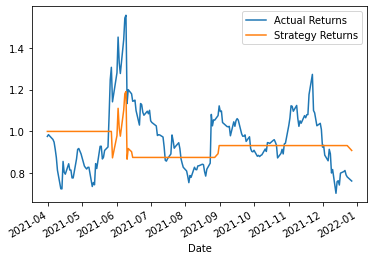

In [33]:
# Plot the actual returns versus the strategy returns
(1 + predictions_df[["Actual Returns", "Strategy Returns"]]).cumprod().plot()
# Baseline with 6 months training data and new SMAs


### Plot Entry and Exit Points of Dual Moving Average Crossover Trading Strategy

In [34]:
# Visualize entry positions relative to close price
entry = signals_df[signals_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize exit positions relative to close price
exit = signals_df[signals_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the close price for the investment
security_close = signals_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the moving averages
moving_avgs = signals_df[['SMA_Fast', 'SMA_Slow']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay the plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
    title="GME Dual Moving Average Trading Algorithm"
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [37]:
# Visualize entry positions relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize exit positions relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize the moving averages
moving_avgs = signals_df[['SMA_Fast', 'SMA_Slow']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay the plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(
    title="GME Dual Moving Average Trading Algorithm"
)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Step 2: Set an `initial_capital` variable to `100000` to represent the starting value (100,000) of your simulated portfolio. Be sure to create this variable as a floating point number.

In [38]:
# Set the initial_capital to 100000
initial_capital = float(100000)

## Step 3: Set a `share_size` variable to negative 500 shares (-500).

In [39]:
# Set the share_size to -500
# In a short-position strategy, shares are sold before they are bought 
share_size = 500

## Step 4: Create a new column named “Position” by multiplying the `share_size` value by the values in the “Signal” column.

In [40]:
# Create a column named "Position" by multiplying the share_size by the Signal
# Sell a position (-500 shares) when the dual moving average crossover Signal equals 1 (SMA50 is less than SMA100)
# Buy a position (500 shares) when the dual moving average crossover Signal equals 0 (SMA50 is greater than SMA100)
signals_df["Position"] = share_size * signals_df["Signal"]

# Review the DataFrame
signals_df.tail()

,Close,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Actual Returns,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2021-12-20,157.139999,150.729998,155.675998,0.0,0.0,0.009638,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-21,158.119995,152.815997,153.706998,0.0,0.0,0.006236,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-22,154.000000,153.897998,151.741998,1.0,1.0,-0.026056,-0.000000,500.0,500.0,77000.0000,68700.005,145700.0050,0.000000,0.45700
2021-12-23,152.139999,155.407998,151.379999,1.0,0.0,-0.012078,-0.012078,500.0,0.0,76069.9995,68700.005,144770.0045,-0.006383,0.44770
2021-12-27,148.309998,153.941998,150.309999,1.0,0.0,-0.025174,-0.025174,500.0,0.0,74154.9990,68700.005,142855.0040,-0.013228,0.42855


## Step 5: Create a new column named “Entry/Exit Position” by calling the `diff` function on the “Position” column.

In [41]:
# Find the points in time where a 500 share position is bought or sold
signals_df["Entry/Exit Position"] = signals_df["Position"].diff()

# Review the DataFrame
signals_df.tail()

,Close,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Actual Returns,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2021-12-20,157.139999,150.729998,155.675998,0.0,0.0,0.009638,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-21,158.119995,152.815997,153.706998,0.0,0.0,0.006236,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-22,154.000000,153.897998,151.741998,1.0,1.0,-0.026056,-0.000000,500.0,500.0,77000.0000,68700.005,145700.0050,0.000000,0.45700
2021-12-23,152.139999,155.407998,151.379999,1.0,0.0,-0.012078,-0.012078,500.0,0.0,76069.9995,68700.005,144770.0045,-0.006383,0.44770
2021-12-27,148.309998,153.941998,150.309999,1.0,0.0,-0.025174,-0.025174,500.0,0.0,74154.9990,68700.005,142855.0040,-0.013228,0.42855


## Step 6: Create a new column named “Portfolio Holdings” by multiplying the “Close” prices of VNQ by the values in the “Position” column.


In [42]:
# Create a Portfolio Holdings column by multiplying the Close price by the Position
signals_df["Portfolio Holdings"] = signals_df["Close"] * signals_df["Position"]


# Review the DataFrame
signals_df.tail()

,Close,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Actual Returns,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2021-12-20,157.139999,150.729998,155.675998,0.0,0.0,0.009638,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-21,158.119995,152.815997,153.706998,0.0,0.0,0.006236,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-22,154.000000,153.897998,151.741998,1.0,1.0,-0.026056,-0.000000,500.0,500.0,77000.0000,68700.005,145700.0050,0.000000,0.45700
2021-12-23,152.139999,155.407998,151.379999,1.0,0.0,-0.012078,-0.012078,500.0,0.0,76069.9995,68700.005,144770.0045,-0.006383,0.44770
2021-12-27,148.309998,153.941998,150.309999,1.0,0.0,-0.025174,-0.025174,500.0,0.0,74154.9990,68700.005,142855.0040,-0.013228,0.42855


## Step 7: Create a new column named “Portfolio Cash” by subtracting the cumulative sum of the trades that the “Entry/Exit Position” column indicates from the `initial_capital` value.

In [43]:
# To calculate Portfolio Cash, subtract the cumulative sum of the trade cost/proceeds from the initial_capital
# The trade cost proceeds are calculated by multiplying the Close price by Entry/Exit Position
signals_df["Portfolio Cash"] = (
    initial_capital - (signals_df["Close"] * signals_df["Entry/Exit Position"]).cumsum()
)

# Review the DataFrame
signals_df.tail()

,Close,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Actual Returns,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2021-12-20,157.139999,150.729998,155.675998,0.0,0.0,0.009638,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-21,158.119995,152.815997,153.706998,0.0,0.0,0.006236,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-22,154.000000,153.897998,151.741998,1.0,1.0,-0.026056,-0.000000,500.0,500.0,77000.0000,68700.005,145700.0050,0.000000,0.45700
2021-12-23,152.139999,155.407998,151.379999,1.0,0.0,-0.012078,-0.012078,500.0,0.0,76069.9995,68700.005,144770.0045,-0.006383,0.44770
2021-12-27,148.309998,153.941998,150.309999,1.0,0.0,-0.025174,-0.025174,500.0,0.0,74154.9990,68700.005,142855.0040,-0.013228,0.42855


## Step 8: Create a new column named “Portfolio Total” by adding the values of the “Portfolio Cash” and “Portfolio Holdings” columns.

In [44]:
# Calculate the Portfolio Total value by adding Portfolio Cash and Portfolio Holdings 
signals_df["Portfolio Total"] = signals_df["Portfolio Cash"] + signals_df["Portfolio Holdings"]

# Review the DataFrame
signals_df.tail()

,Close,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Actual Returns,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2021-12-20,157.139999,150.729998,155.675998,0.0,0.0,0.009638,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-21,158.119995,152.815997,153.706998,0.0,0.0,0.006236,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-22,154.000000,153.897998,151.741998,1.0,1.0,-0.026056,-0.000000,500.0,500.0,77000.0000,68700.005,145700.0050,0.000000,0.45700
2021-12-23,152.139999,155.407998,151.379999,1.0,0.0,-0.012078,-0.012078,500.0,0.0,76069.9995,68700.005,144770.0045,-0.006383,0.44770
2021-12-27,148.309998,153.941998,150.309999,1.0,0.0,-0.025174,-0.025174,500.0,0.0,74154.9990,68700.005,142855.0040,-0.013228,0.42855


## Step 9: Create a new column named “Portfolio Daily Returns” by calling the `pct_change` function on the “Portfolio Total” column.

In [45]:
# Calculate the Portfolio Daily Returns based on the Portfolio Total
signals_df["Portfolio Daily Returns"] = signals_df["Portfolio Total"].pct_change()

# Review the DataFrame
signals_df.tail()

,Close,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Actual Returns,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2021-12-20,157.139999,150.729998,155.675998,0.0,0.0,0.009638,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-21,158.119995,152.815997,153.706998,0.0,0.0,0.006236,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-22,154.000000,153.897998,151.741998,1.0,1.0,-0.026056,-0.000000,500.0,500.0,77000.0000,68700.005,145700.0050,0.000000,0.45700
2021-12-23,152.139999,155.407998,151.379999,1.0,0.0,-0.012078,-0.012078,500.0,0.0,76069.9995,68700.005,144770.0045,-0.006383,0.44770
2021-12-27,148.309998,153.941998,150.309999,1.0,0.0,-0.025174,-0.025174,500.0,0.0,74154.9990,68700.005,142855.0040,-0.013228,0.42855


## Step 10: Create a new column named “Portfolio Cumulative Returns” by calling the `cum_prod` function on the “Portfolio Daily Returns” column.

In [46]:
# Calculate the Portfolio Cumulative Returns based on the Portfolio Daily Returns
signals_df["Portfolio Cumulative Returns"] = (
    1 + signals_df["Portfolio Daily Returns"]
).cumprod() - 1

# Review the DataFrame
signals_df.tail()

,Close,SMA_Fast,SMA_Slow,Signal,Entry/Exit,Actual Returns,Strategy Returns,Position,Entry/Exit Position,Portfolio Holdings,Portfolio Cash,Portfolio Total,Portfolio Daily Returns,Portfolio Cumulative Returns
Date,,,,,,,,,,,,,,
2021-12-20,157.139999,150.729998,155.675998,0.0,0.0,0.009638,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-21,158.119995,152.815997,153.706998,0.0,0.0,0.006236,0.000000,0.0,0.0,0.0000,145700.005,145700.0050,0.000000,0.45700
2021-12-22,154.000000,153.897998,151.741998,1.0,1.0,-0.026056,-0.000000,500.0,500.0,77000.0000,68700.005,145700.0050,0.000000,0.45700
2021-12-23,152.139999,155.407998,151.379999,1.0,0.0,-0.012078,-0.012078,500.0,0.0,76069.9995,68700.005,144770.0045,-0.006383,0.44770
2021-12-27,148.309998,153.941998,150.309999,1.0,0.0,-0.025174,-0.025174,500.0,0.0,74154.9990,68700.005,142855.0040,-0.013228,0.42855


## Step 11: Use the `hvplot` function to plot the short-position DMAC trading strategy against its backtesting results.

In [47]:
# Visualize the entry positions relative to the Portfolio Total
entry = signals_df[signals_df["Entry/Exit"] == 1.0]["Portfolio Total"].hvplot.scatter(
    color='purple',
    marker='^',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize the exit positions relative to the Portfolio Total
exit = signals_df[signals_df["Entry/Exit"] == -1.0]["Portfolio Total"].hvplot.scatter(
    color='orange',
    marker='v',
    legend=False, 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Visualize Portfolio Total for the investment
total_portfolio_value = signals_df[["Portfolio Total"]].hvplot(
    line_color="lightgray", 
    ylabel="Total Portfolio Value", 
    width=1000, 
    height=400
)

# Overlay the entry, exit and total_portfolio_value plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(
    title="GME Algorithm - Total Portfolio Value",
    yformatter='%.0f'
)

:Overlay
   .Curve.I                    :Curve   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [Date]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [Date]   (Portfolio Total)

## Step 12: Answer the following question:

**Question:** Does it appear that this algorithm suits a short-position trading strategy?
    
**Answer:** Although the value of the portfolio did fall below the initial investment of 100,000,  the drop in the stock price in 2008 and 2009 benefited the algorithm's short-position strategy and the portfolio did make money.